In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Gaussian Process Regression for SAR Data Interpolation

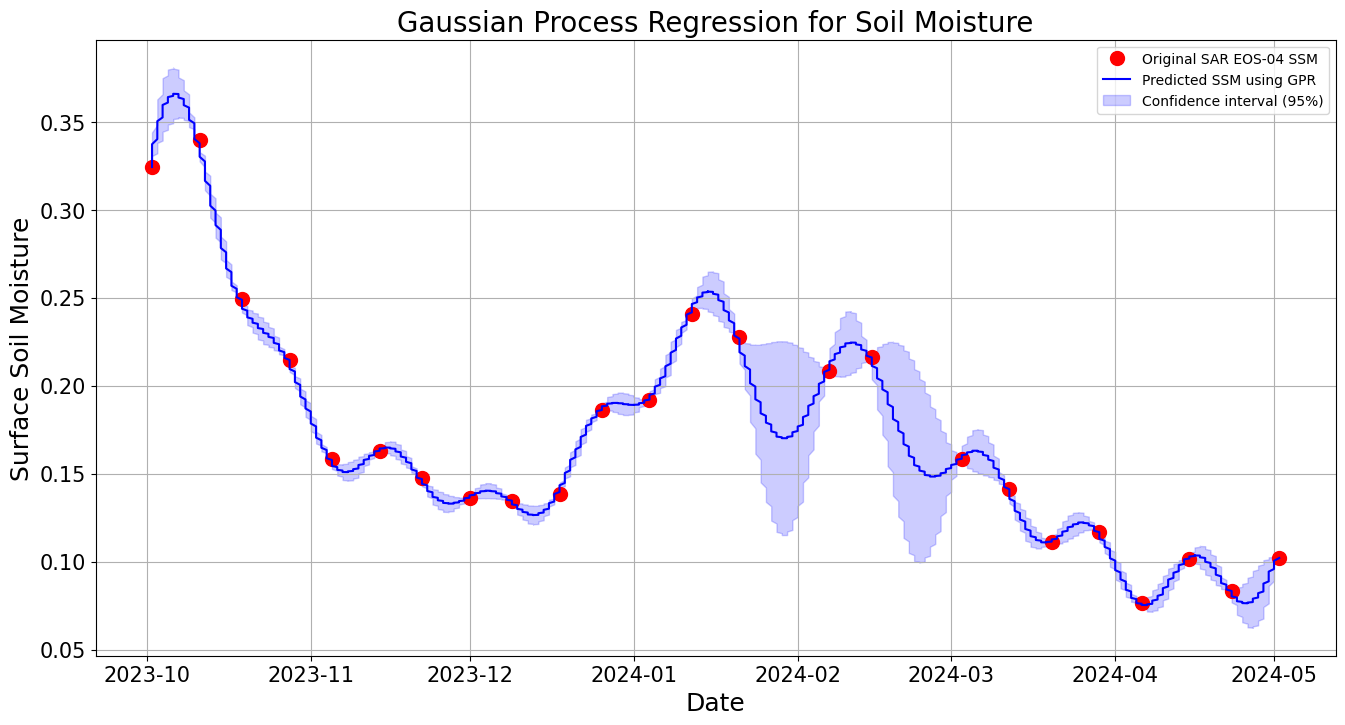

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# SAR Data
file_path = '/content/drive/MyDrive/SAR Data/Soil Moisture SAR.xlsx'
df = pd.read_excel(file_path)

# Converting 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sorting
df = df.sort_values(by='Date')

# Converting dates to numerical values (days since the first date)
reference_date = df['Date'].min()
df['Days'] = (df['Date'] - reference_date).dt.days

# Features and target
timestamps = df['Days'].values.reshape(-1, 1)
soil_moisture = df['Average Soil Moisture'].values

# Kernel with adjusted parameters
kernel = C(0.2, (1e-2, 0.5)) * RBF(1.0, (1e-2, 1e2))

# Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(timestamps, soil_moisture)

# Finer time points for smooth prediction
fine_timestamps = np.linspace(timestamps.min(), timestamps.max(), 1000).reshape(-1, 1)

# Soil moisture values at finer resolution
soil_moisture_pred, sigma = gp.predict(fine_timestamps, return_std=True)

# Converting fine_timestamps back to actual dates for plotting
fine_dates = [reference_date + pd.Timedelta(days=int(day)) for day in fine_timestamps.ravel()]

# DataFrame for the predictions
predictions_df = pd.DataFrame({
    'Date': fine_dates,
    'Predicted Soil Moisture': soil_moisture_pred
})

# Saving the predictions to a CSV file
output_file_path = '/content/drive/MyDrive/SAR Data/Soil_Moisture_Predictions.csv'
predictions_df.to_csv(output_file_path, index=False)

# Plot
plt.figure(figsize=(16, 8))
plt.plot(df['Date'], soil_moisture, 'r.', markersize=20, label='Original SAR EOS-04 SSM')
plt.plot(fine_dates, soil_moisture_pred, 'b-', label='Predicted SSM using GPR')
plt.fill_between(fine_dates,
                 soil_moisture_pred - 1.96 * sigma,
                 soil_moisture_pred + 1.96 * sigma,
                 alpha=0.2, color='blue', label='Confidence interval (95%)')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Surface Soil Moisture', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Gaussian Process Regression for Soil Moisture', fontsize = 20)
plt.legend()
plt.grid(True)
plt.show()

SAR and SMAP Data Comparison

RMSE: 0.06855487695430702


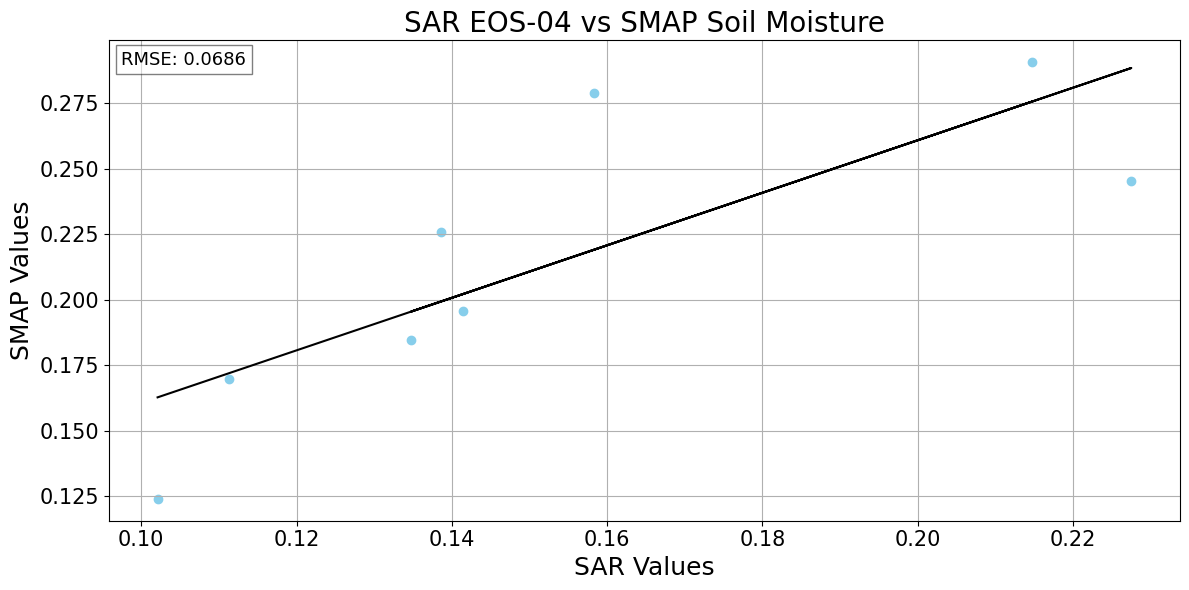

Number of matching dates: 8
Date range: 2023-10-28 00:00:00 to 2024-05-02 00:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# File paths
sar_data_path = '/content/drive/MyDrive/SAR Data/Soil Moisture SAR.xlsx'
smap_data_path = '/content/drive/MyDrive/Soil Moisture SMAP.xlsx'

# datasets
sar_df = pd.read_excel(sar_data_path, parse_dates=['Date'])
smap_df = pd.read_excel(smap_data_path, parse_dates=['Date'])

# setting 'Date' as the index for both dataframes
sar_df.set_index('Date', inplace=True)
smap_df.set_index('Date', inplace=True)

# aligning the datasets
aligned_data = sar_df.join(smap_df, how='inner')

# relevant columns
SAR_values = aligned_data['Average Soil Moisture']  # Replace with your column name
SMAP_values = aligned_data['soil_moisture']  # Replace with your column name

# RMSE
rmse = np.sqrt(mean_squared_error(SAR_values, SMAP_values))
print(f'RMSE: {rmse}')

# linear regression model for the best-fit line
model = LinearRegression()
model.fit(SAR_values.values.reshape(-1, 1), SMAP_values.values)
best_fit_line = model.predict(SAR_values.values.reshape(-1, 1))

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(SAR_values, SMAP_values, color = 'skyblue')
plt.plot(SAR_values, best_fit_line, color='black')
plt.text(0.07, 0.96, f'RMSE: {rmse:.4f}', fontsize=13, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('', fontsize = 18)
plt.ylabel('SMAP Values', fontsize = 18)
plt.title('SAR EOS-04 vs SMAP Soil Moisture', fontsize = 20)
plt.grid(True)
plt.tight_layout()
plt.show()

# additional statistics
print(f'Number of matching dates: {len(aligned_data)}')
print(f'Date range: {aligned_data.index.min()} to {aligned_data.index.max()}')


Interploated SAR Data vs SMAP Data

RMSE: 0.06784910692790933


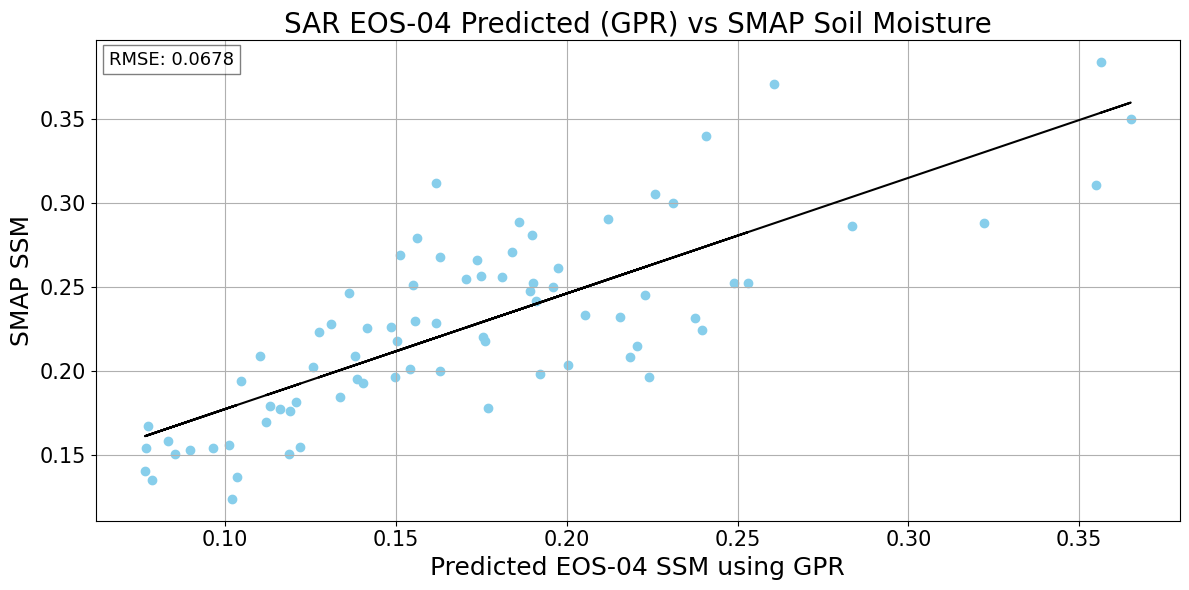

Number of matching dates: 78
Date range: 2023-10-04 00:00:00 to 2024-05-02 00:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# File paths
daily_predictions_path = '/content/drive/MyDrive/SAR Data/average_soil_moisture_predictions.csv'
smap_data_path = '/content/drive/MyDrive/Soil Moisture SMAP.xlsx'

# Datasets
daily_pred_df = pd.read_csv(daily_predictions_path, parse_dates=['Date'])
smap_df = pd.read_excel(smap_data_path, parse_dates=['Date'])

# Setting 'Date' as the index for both dataframes
daily_pred_df.set_index('Date', inplace=True)
smap_df.set_index('Date', inplace=True)

# Aligning the datasets
aligned_data = daily_pred_df.join(smap_df, how='inner')

# Relevant columns
predicted_values = aligned_data['Predicted Soil Moisture']  # Replace with your column name
actual_values = aligned_data['soil_moisture']  # Replace with your column name

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f'RMSE: {rmse}')

# linear regression model for the best-fit line
model = LinearRegression()
model.fit(predicted_values.values.reshape(-1, 1), actual_values.values)
best_fit_line = model.predict(predicted_values.values.reshape(-1, 1))

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(predicted_values, actual_values, color = 'skyblue')
plt.plot(predicted_values, best_fit_line, color='black')
plt.text(0.07, 0.96, f'RMSE: {rmse:.4f}', fontsize=13, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Predicted EOS-04 SSM using GPR', fontsize = 18)
plt.ylabel('SMAP SSM', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('SAR EOS-04 Predicted (GPR) vs SMAP Soil Moisture', fontsize = 20)
plt.grid(True)
plt.tight_layout()
plt.show()

# additional statistics
print(f'Number of matching dates: {len(aligned_data)}')
print(f'Date range: {aligned_data.index.min()} to {aligned_data.index.max()}')

Coorelation between SAR and CYGNSS Data

RMSE: 0.06987121088620904


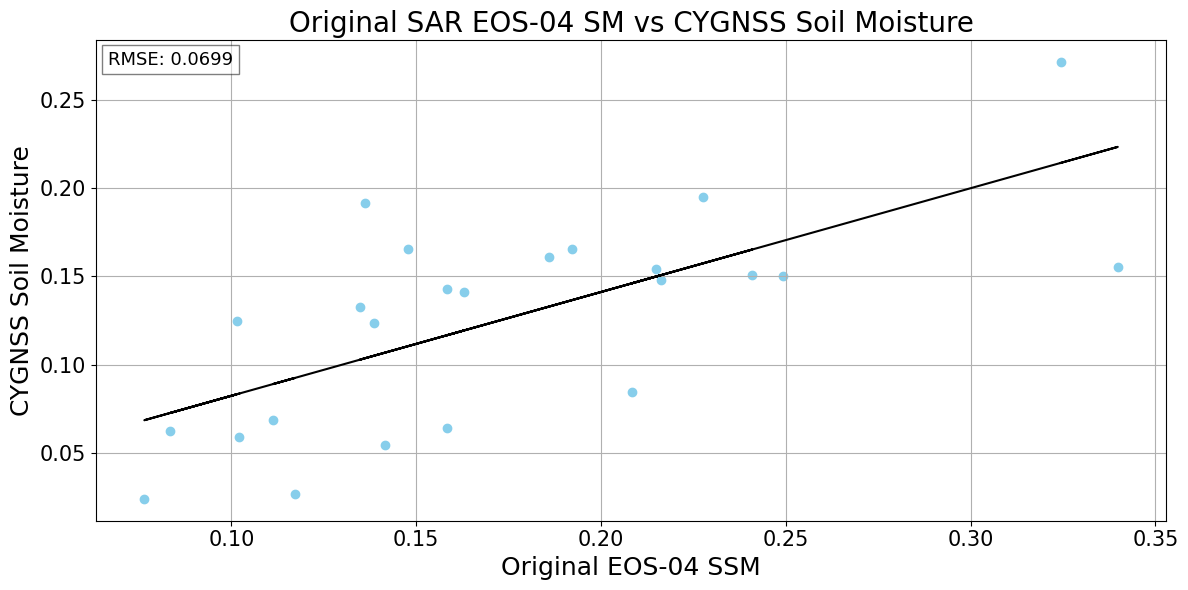

Number of matching dates: 24
Date range: 2023-10-02 00:00:00 to 2024-05-02 00:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# file paths
sar_data_path = '/content/drive/MyDrive/SAR Data/Soil Moisture SAR.xlsx'
cygnss_data_path = '/content/drive/MyDrive/CYGNSS_L3_SOIL_MOISTURE_V1.0_1.0-20240724_111557/average_soil_moisture_cygnss.xlsx'

# datasets
sar_df = pd.read_excel(sar_data_path, parse_dates=['Date'])
cygnss_df = pd.read_excel(cygnss_data_path, parse_dates=['Date'])

# setting 'Date' as the index for both dataframes
sar_df.set_index('Date', inplace=True)
cygnss_df.set_index('Date', inplace=True)

# aligning the datasets to match rows where the dates are same in the dataframes
aligned_data = sar_df.join(cygnss_df, how='inner')

SAR_values = aligned_data['Average Soil Moisture']
CYGNSS_values = aligned_data['Soil Moisture']

# RMSE
rmse = np.sqrt(mean_squared_error(SAR_values, CYGNSS_values))
print(f'RMSE: {rmse}')

# linear regression model for the best-fit line
model = LinearRegression()
model.fit(SAR_values.values.reshape(-1, 1), CYGNSS_values.values)
best_fit_line = model.predict(SAR_values.values.reshape(-1, 1))

# plotting the scatter plot with the best-fit line
plt.figure(figsize=(12, 6))
plt.scatter(SAR_values, CYGNSS_values, color='skyblue')
plt.plot(SAR_values, best_fit_line, color='black')
plt.text(0.07, 0.96, f'RMSE: {rmse:.4f}', fontsize=13, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Original EOS-04 SSM', fontsize = 18)
plt.ylabel('CYGNSS Soil Moisture', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Original SAR EOS-04 SM vs CYGNSS Soil Moisture', fontsize = 20)
plt.grid(True)
plt.tight_layout()
plt.show()

# additional statistics
print(f'Number of matching dates: {len(aligned_data)}')
print(f'Date range: {aligned_data.index.min()} to {aligned_data.index.max()}')


Interpolated SAR vs CYGNSS Data

RMSE: 0.06259842353174803


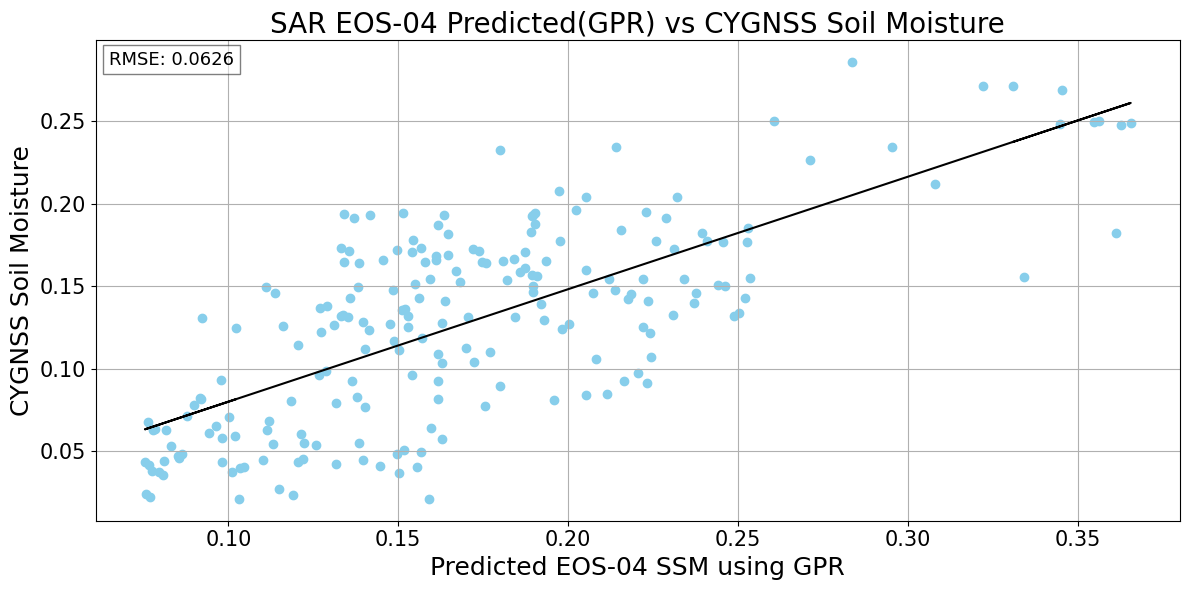

Number of matching dates: 211
Date range: 2023-10-02 00:00:00 to 2024-05-02 00:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# File paths
daily_predictions_path = '/content/drive/MyDrive/SAR Data/average_soil_moisture_predictions.csv'
cygnss_data_path = '/content/drive/MyDrive/CYGNSS_L3_SOIL_MOISTURE_V1.0_1.0-20240724_111557/average_soil_moisture_cygnss.xlsx'

# Datasets
daily_pred_df = pd.read_csv(daily_predictions_path, parse_dates=['Date'])
cygnss_df = pd.read_excel(cygnss_data_path, parse_dates=['Date'])

# Setting 'Date' as the index for both dataframes
daily_pred_df.set_index('Date', inplace=True)
cygnss_df.set_index('Date', inplace=True)

# Aligning the datasets
aligned_data = daily_pred_df.join(cygnss_df, how='inner').dropna()

# Relevant columns
predicted_values = aligned_data['Predicted Soil Moisture']
CYGNSS_values = aligned_data['Soil Moisture']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(CYGNSS_values, predicted_values))
print(f'RMSE: {rmse}')

# linear regression model for the best-fit line
model = LinearRegression()
model.fit(predicted_values.values.reshape(-1, 1), CYGNSS_values.values)
best_fit_line = model.predict(predicted_values.values.reshape(-1, 1))

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(predicted_values, CYGNSS_values, color = 'skyblue')
plt.plot(predicted_values, best_fit_line, color='black')
plt.text(0.07, 0.96, f'RMSE: {rmse:.4f}', fontsize=13, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Predicted EOS-04 SSM using GPR', fontsize = 18)
plt.ylabel('CYGNSS Soil Moisture', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('SAR EOS-04 Predicted(GPR) vs CYGNSS Soil Moisture', fontsize = 20)
plt.grid(True)
plt.tight_layout()
plt.show()

# additional statistics
print(f'Number of matching dates: {len(aligned_data)}')
print(f'Date range: {aligned_data.index.min()} to {aligned_data.index.max()}')

SAR and CYGNSS Soil Moisture against Precipitation Data

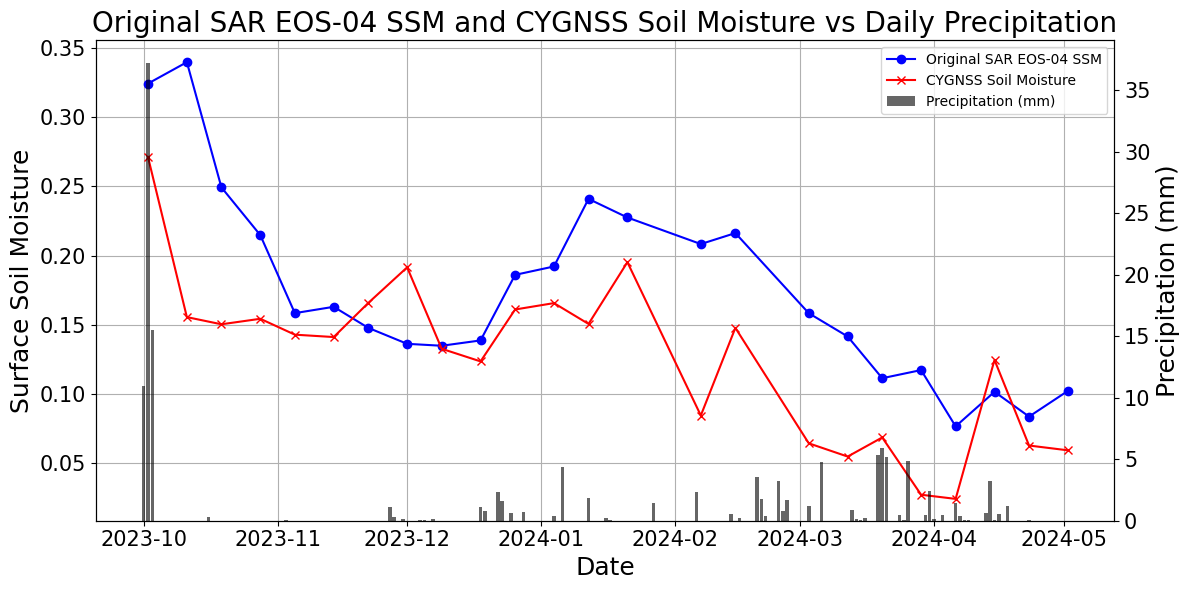

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# file paths
sar_data_path = '/content/drive/MyDrive/SAR Data/Soil Moisture SAR.xlsx'
cygnss_data_path = '/content/drive/MyDrive/CYGNSS_L3_SOIL_MOISTURE_V1.0_1.0-20240724_111557/average_soil_moisture_cygnss.xlsx'
precipitation_path = '/content/drive/MyDrive/Earth Engine Exports/daily_precipitation_csv.csv'

# datasets
sar_df = pd.read_excel(sar_data_path, parse_dates=['Date'])
cygnss_df = pd.read_excel(cygnss_data_path, parse_dates=['Date'])
precipitation_df = pd.read_csv(precipitation_path, parse_dates=['Date'])

# setting 'Date' as the index for both dataframes
sar_df.set_index('Date', inplace=True)
cygnss_df.set_index('Date', inplace=True)
precipitation_df.set_index('Date', inplace=True)
precipitation_df.index = pd.to_datetime(precipitation_df.index, dayfirst = True)

# aligning the datasets to match rows where the dates are same in the dataframes
aligned_data = sar_df.join(cygnss_df, how='inner')

# relevant columns
SAR_values = aligned_data['Average Soil Moisture']
CYGNSS_values = aligned_data['Soil Moisture']
precipitation_values = precipitation_df['Precipitation']

# plots
# creating the figure and primary axis for soil moisture
fig, ax1 = plt.subplots(figsize=(12, 6))

# precipitation data on the secondary y-axis
ax2 = ax1.twinx()
ax2.bar(precipitation_df.index, precipitation_values, label='Precipitation (mm)', color='black', alpha=0.6)

# plotting the SAR and CYGNSS data on the primary y-axis
ax1.plot(aligned_data.index, SAR_values, label='Original SAR EOS-04 SSM', color='blue', marker='o')
ax1.plot(aligned_data.index, CYGNSS_values, label='CYGNSS Soil Moisture', color='red', marker='x')

# Setting the fontsize for x-ticks and y-ticks
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

# labels, title, grid
ax1.set_xlabel('Date', fontsize=18)
ax1.set_ylabel('Surface Soil Moisture', fontsize=18)

ax2.set_ylabel('Precipitation (mm)', fontsize=18, color='black')

plt.title('Original SAR EOS-04 SSM and CYGNSS Soil Moisture vs Daily Precipitation', fontsize=20)
ax1.grid(True)

# legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()


SAR and CYGNSS values vs Daily Surface Temperature

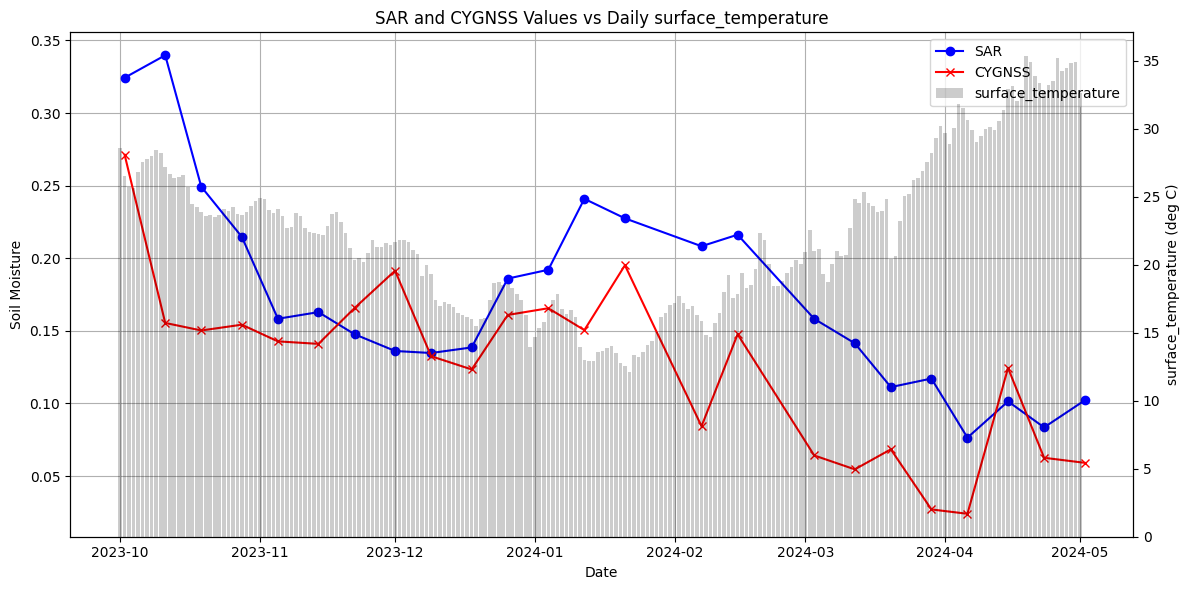

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# file paths
sar_data_path = '/content/drive/MyDrive/SAR Data/Soil Moisture SAR.xlsx'
cygnss_data_path = '/content/drive/MyDrive/CYGNSS_L3_SOIL_MOISTURE_V1.0_1.0-20240724_111557/average_soil_moisture_cygnss.xlsx'
daily_surface_temperature_path = '/content/drive/MyDrive/Earth Engine Exports/average_surface_temperature.csv'

# datasets
sar_df = pd.read_excel(sar_data_path, parse_dates=['Date'])
cygnss_df = pd.read_excel(cygnss_data_path, parse_dates=['Date'])
surface_temp_df = pd.read_csv(daily_surface_temperature_path, parse_dates=['date'])

# setting 'Date' as the index for both dataframes
sar_df.set_index('Date', inplace=True)
cygnss_df.set_index('Date', inplace=True)
surface_temp_df.set_index('date', inplace=True)
surface_temp_df.index = pd.to_datetime(surface_temp_df.index, dayfirst = True)

# aligning the datasets to match rows where the dates are same in the dataframes
aligned_data = sar_df.join(cygnss_df, how='inner')

# relevant columns
SAR_values = aligned_data['Average Soil Moisture']
CYGNSS_values = aligned_data['Soil Moisture']
surface_temperature_values = surface_temp_df['mean_temperature_C']

# plots
# creating the figure and primary axis for soil moisture
fig, ax1 = plt.subplots(figsize=(12, 6))

# surface_temperature data on the secondary y-axis
ax2 = ax1.twinx()
ax2.bar(surface_temp_df.index, surface_temperature_values, label='surface_temperature', color='black', alpha=0.2)

# plotting the SAR and CYGNSS data on the primary y-axis
ax1.plot(aligned_data.index, SAR_values, label='SAR', color='blue', marker='o')
ax1.plot(aligned_data.index, CYGNSS_values, label='CYGNSS', color='red', marker='x')

# labels, title, grid
ax1.set_xlabel('Date')
ax1.set_ylabel('Soil Moisture')
ax2.set_ylabel('surface_temperature (deg C)', color='black')
plt.title('SAR and CYGNSS Values vs Daily surface_temperature')
ax1.grid(True)
plt.xticks(rotation=45)

# legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()

SAR and CYGNSS Values vs Evapotranspiration data

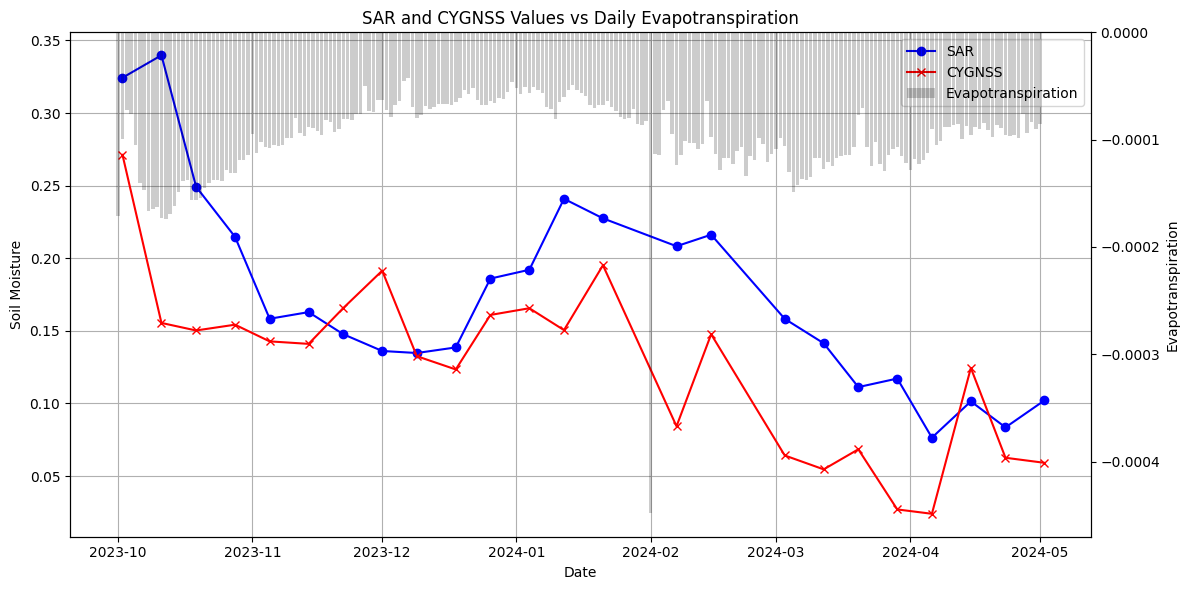

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# file paths
sar_data_path = '/content/drive/MyDrive/SAR Data/Soil Moisture SAR.xlsx'
cygnss_data_path = '/content/drive/MyDrive/CYGNSS_L3_SOIL_MOISTURE_V1.0_1.0-20240724_111557/average_soil_moisture_cygnss.xlsx'
et_path = '/content/drive/MyDrive/Earth Engine Exports/daily_et_averages.csv'

# datasets
sar_df = pd.read_excel(sar_data_path, parse_dates=['Date'])
cygnss_df = pd.read_excel(cygnss_data_path, parse_dates=['Date'])
et_df = pd.read_csv(et_path, parse_dates=['date'])

# setting 'Date' as the index for both dataframes
sar_df.set_index('Date', inplace=True)
cygnss_df.set_index('Date', inplace=True)
et_df.set_index('date', inplace=True)
et_df.index = pd.to_datetime(et_df.index, dayfirst = True)

# aligning the datasets to match rows where the dates are same in the dataframes
aligned_data = sar_df.join(cygnss_df, how='inner')

# relevant columns
SAR_values = aligned_data['Average Soil Moisture']
CYGNSS_values = aligned_data['Soil Moisture']
et_values = et_df['ET']

# plots
# creating the figure and primary axis for soil moisture
fig, ax1 = plt.subplots(figsize=(12, 6))

# ET data on the secondary y-axis
ax2 = ax1.twinx()
ax2.bar(et_df.index, et_values, label='Evapotranspiration', color='black', alpha=0.2)

# plotting the SAR and CYGNSS data on the primary y-axis
ax1.plot(aligned_data.index, SAR_values, label='SAR', color='blue', marker='o')
ax1.plot(aligned_data.index, CYGNSS_values, label='CYGNSS', color='red', marker='x')

# labels, title, grid
ax1.set_xlabel('Date')
ax1.set_ylabel('Soil Moisture')
ax2.set_ylabel('Evapotranspiration', color='black')
plt.title('SAR and CYGNSS Values vs Daily Evapotranspiration')
ax1.grid(True)
plt.xticks(rotation=45)

# legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()

RMSE: 0.012446385476639262


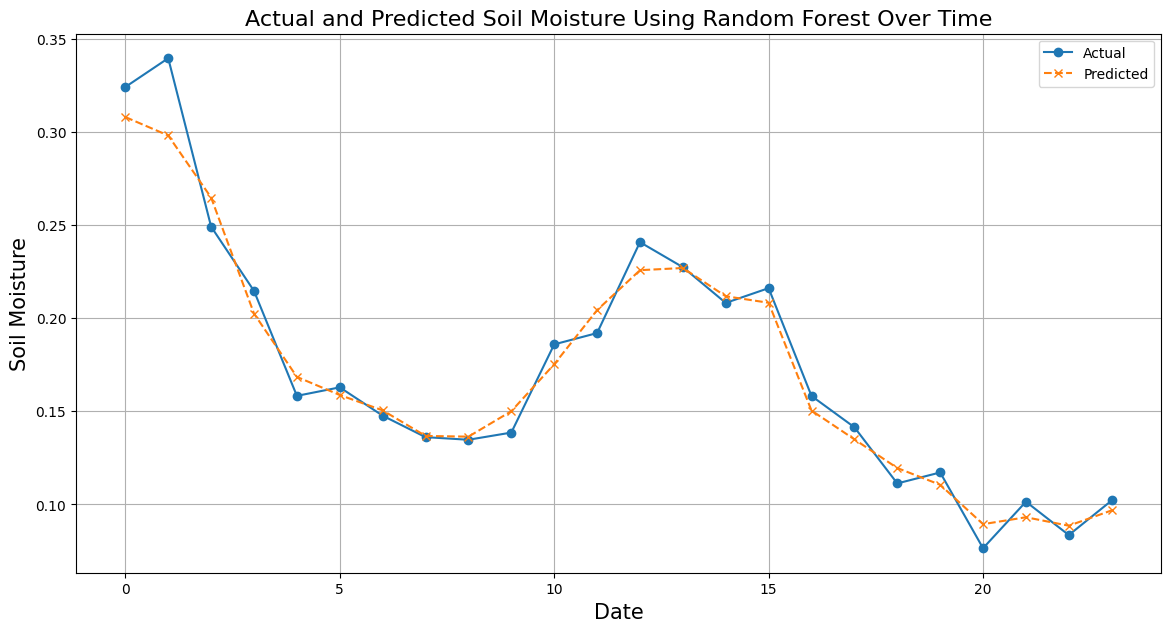

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/SAR Data/Soil Moisture SAR.xlsx'
df = pd.read_excel(file_path)

# Ensure the data is clean by dropping NaN values
df = df.dropna()

# Assuming 'Average Soil Moisture' is the target variable
X = df.drop('Average Soil Moisture', axis=1)
y = df['Average Soil Moisture']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model using the entire dataset
rf_model.fit(X_scaled, y)

# Make predictions using the same dataset used for training
predictions = rf_model.predict(X_scaled)

# Calculate RMSE (optional, since we're not splitting the data)
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f'RMSE: {rmse}')

# Assuming df has a DateTimeIndex or similar for plotting against time
plt.figure(figsize=(14, 7))
plt.plot(df.index, y.values, label='Actual', marker='o', linestyle='-')
plt.plot(df.index, predictions, label='Predicted', marker='x', linestyle='--')

plt.xlabel('Date', fontsize=15)
plt.ylabel('Soil Moisture', fontsize=15)
plt.title('Actual and Predicted Soil Moisture Using Random Forest Over Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
RMSE: 0.010719889275504884


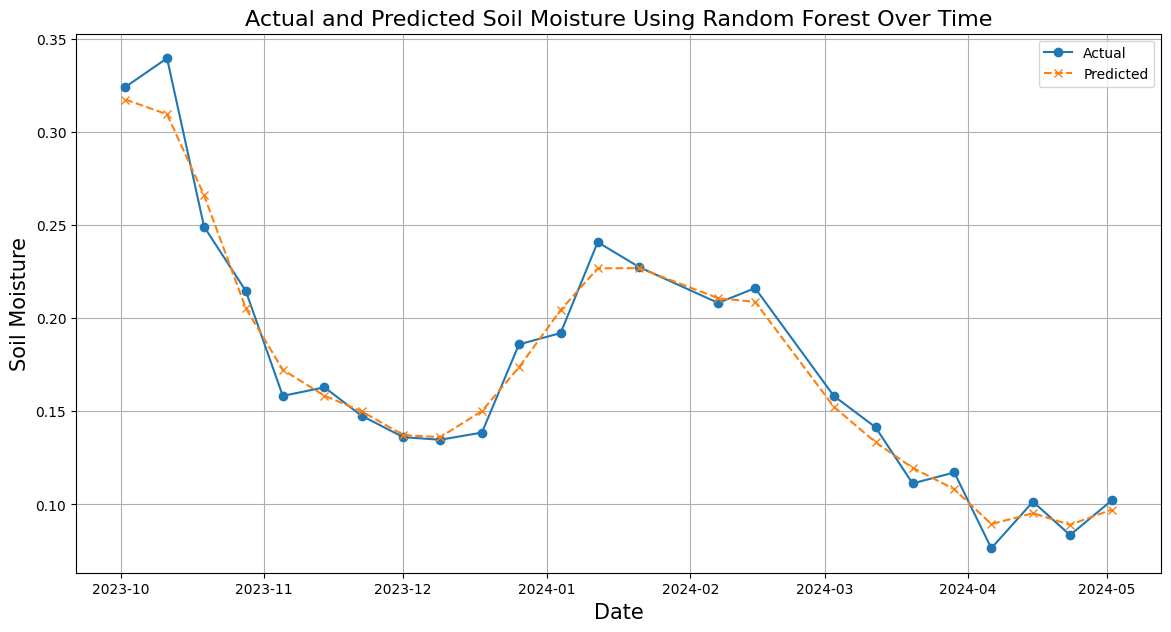

Predictions saved to /content/drive/MyDrive/SAR Data/Soil_Moisture_Predictions_RF.csv


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/SAR Data/Soil Moisture SAR.xlsx'
df = pd.read_excel(file_path)

# Assuming 'Average Soil Moisture' is the target variable
X = df.drop('Average Soil Moisture', axis=1)
y = df['Average Soil Moisture']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_scaled, y)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Train the model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_scaled, y)

# Make predictions
predictions = best_rf_model.predict(X_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], y.values, label='Actual', marker='o', linestyle='-')
plt.plot(df['Date'], predictions, label='Predicted', marker='x', linestyle='--')

plt.xlabel('Date', fontsize=15)
plt.ylabel('Soil Moisture', fontsize=15)
plt.title('Actual and Predicted Soil Moisture Using Random Forest Over Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# Create a DataFrame with dates and predictions
results_df = pd.DataFrame({
    'Date': df['Date'],
    'Predicted_Soil_Moisture': predictions,
})

# Save the results to a CSV file on Google Drive
output_path = '/content/drive/MyDrive/SAR Data/Soil_Moisture_Predictions_RF.csv'
results_df.to_csv(output_path, index=False)
print(f'Predictions saved to {output_path}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
RMSE: 0.006535486599680882


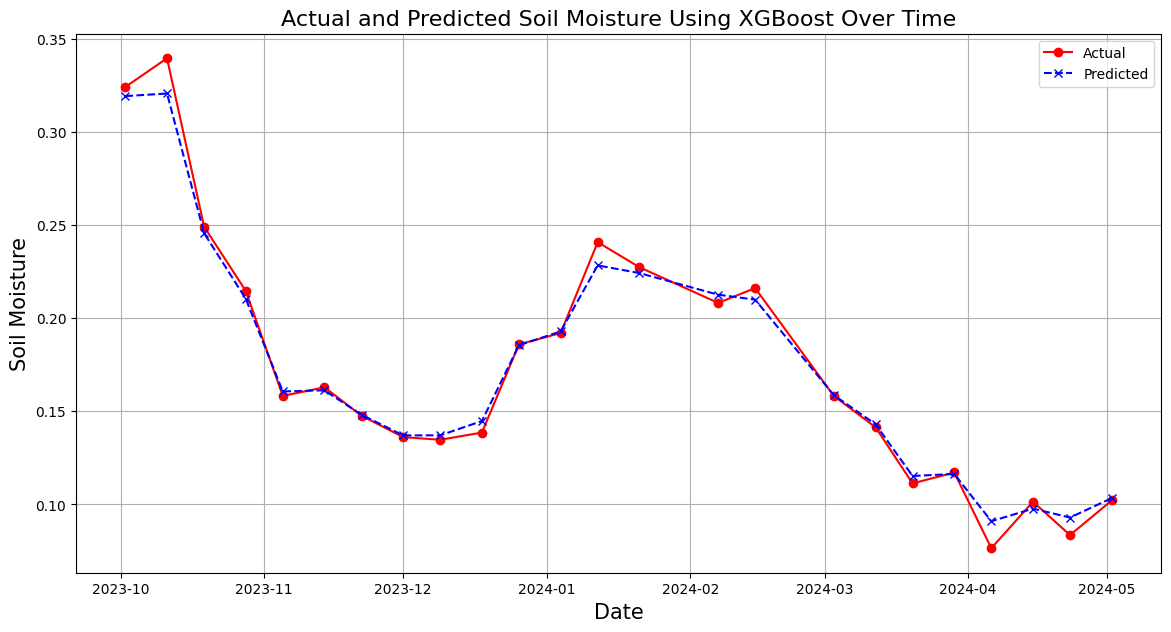

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# Dataset
file_path = '/content/drive/MyDrive/SAR Data/Soil Moisture SAR.xlsx'
df = pd.read_excel(file_path)

X = df.drop('Average Soil Moisture', axis=1)
y = df['Average Soil Moisture']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_scaled, y)

# Best model
best_xgb_model = grid_search.best_estimator_

# Predictions
predictions = best_xgb_model.predict(X_scaled)

# RMSE
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f'RMSE: {rmse}')

# Plot
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], y.values, label='Actual', marker='o', linestyle='-', color = 'red')
plt.plot(df['Date'], predictions, label='Predicted', marker='x', linestyle='--', color = 'blue')

plt.xlabel('Date', fontsize=15)
plt.ylabel('Soil Moisture', fontsize=15)
plt.title('Actual and Predicted Soil Moisture Using XGBoost Over Time', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


Optimised XGBoost Model

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Optimized XGBoost RMSE: 0.036499648687541776
Optimized XGBoost MAE: 0.028994399332002072


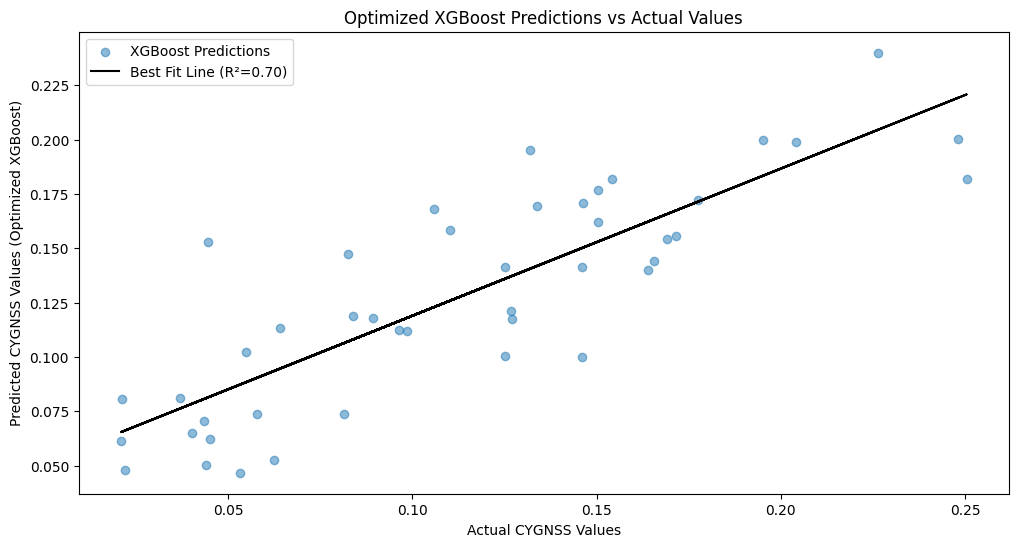

RMSE between Predicted CYGNSS Values and SAR Data: 0.05492432289306431


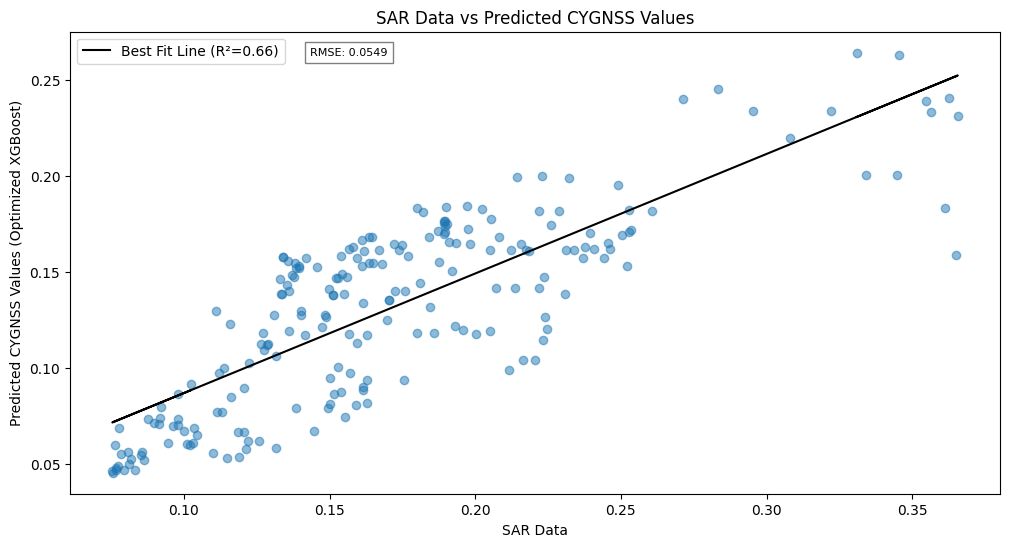

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress

# Data
file_path = '/content/drive/MyDrive/Earth Engine Exports/Combined Data/combined_data.xlsx'
df = pd.read_excel(file_path)

# Feature Engineering
df['SAR_temp'] = df['Interpolated_SAR_Data'] * df['mean_temperature_C']
df['SAR_ET'] = df['Interpolated_SAR_Data'] * df['ET']
features = df[['Interpolated_SAR_Data', 'mean_temperature_C', 'ET', 'Precipitation', 'SAR_temp', 'SAR_ET']]
target = df['CYGNSS_values']

# KNN Imputation for missing values in target
imputer_target = KNNImputer(n_neighbors=3)
target_imputed = imputer_target.fit_transform(target.values.reshape(-1, 1))
target = pd.Series(target_imputed.flatten())

# KNN Imputation for missing values in features
imputer_features = KNNImputer(n_neighbors=3)
features_imputed = imputer_features.fit_transform(features)
features = pd.DataFrame(features_imputed, columns=features.columns) # Convert back to DataFrame

# Feature Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")

# Prediction and evaluation with the best XGBoost model
y_pred_xgb_best = best_model.predict(X_test)
rmse_xgb_best = np.sqrt(mean_squared_error(y_test, y_pred_xgb_best))
mae_xgb_best = mean_absolute_error(y_test, y_pred_xgb_best)

print(f"Optimized XGBoost RMSE: {rmse_xgb_best}")
print(f"Optimized XGBoost MAE: {mae_xgb_best}")

# Visualization for the optimized XGBoost model
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_xgb_best, alpha=0.5, label='XGBoost Predictions')

# Best fit line
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred_xgb_best)
plt.plot(y_test, slope * y_test + intercept, 'k-', label=f'Best Fit Line (R²={r_value**2:.2f})')

plt.xlabel('Actual CYGNSS Values')
plt.ylabel('Predicted CYGNSS Values (Optimized XGBoost)')
plt.title('Optimized XGBoost Predictions vs Actual Values')
plt.legend()
plt.show()

# Adding Predictions to DataFrame for RMSE Comparison
df['Predicted_CYGNSS_XGBoost'] = best_model.predict(features_scaled)

df['SAR_Data'] = df['Interpolated_SAR_Data']

# Dropping rows with missing SAR data or predicted values
df_clean = df.dropna(subset=['SAR_Data', 'Predicted_CYGNSS_XGBoost'])

# RMSE between predicted CYGNSS values and SAR data
rmse_comparison = np.sqrt(mean_squared_error(df_clean['SAR_Data'], df_clean['Predicted_CYGNSS_XGBoost']))

print(f"RMSE between Predicted CYGNSS Values and SAR Data: {rmse_comparison}")

# Visualization for SAR Data vs Predicted CYGNSS Values
plt.figure(figsize=(12, 6))
plt.scatter(df_clean['SAR_Data'], df_clean['Predicted_CYGNSS_XGBoost'], alpha=0.5)

# Best fit line
slope, intercept, r_value, p_value, std_err = linregress(df_clean['SAR_Data'], df_clean['Predicted_CYGNSS_XGBoost'])
plt.plot(df_clean['SAR_Data'], slope * df_clean['SAR_Data'] + intercept, 'k-', label=f'Best Fit Line (R²={r_value**2:.2f})')

# RMSE text at the new coordinates
plt.text(0.3, 0.9543, f'RMSE: {rmse_comparison:.4f}', fontsize=8, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('SAR Data')
plt.ylabel('Predicted CYGNSS Values (Optimized XGBoost)')
plt.title('SAR Data vs Predicted CYGNSS Values')
plt.legend()
plt.show()


Random Forest Model

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Random Forest RMSE: 0.034859065438847904
Optimized Random Forest MAE: 0.02796364837486748


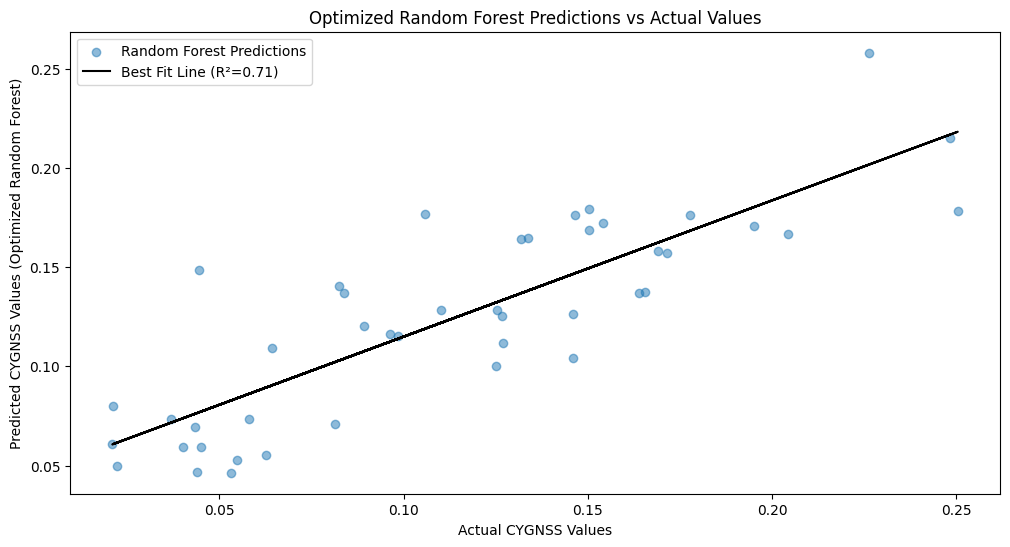

RMSE between Predicted CYGNSS Values and SAR Data (Random Forest): 0.05459141412414595


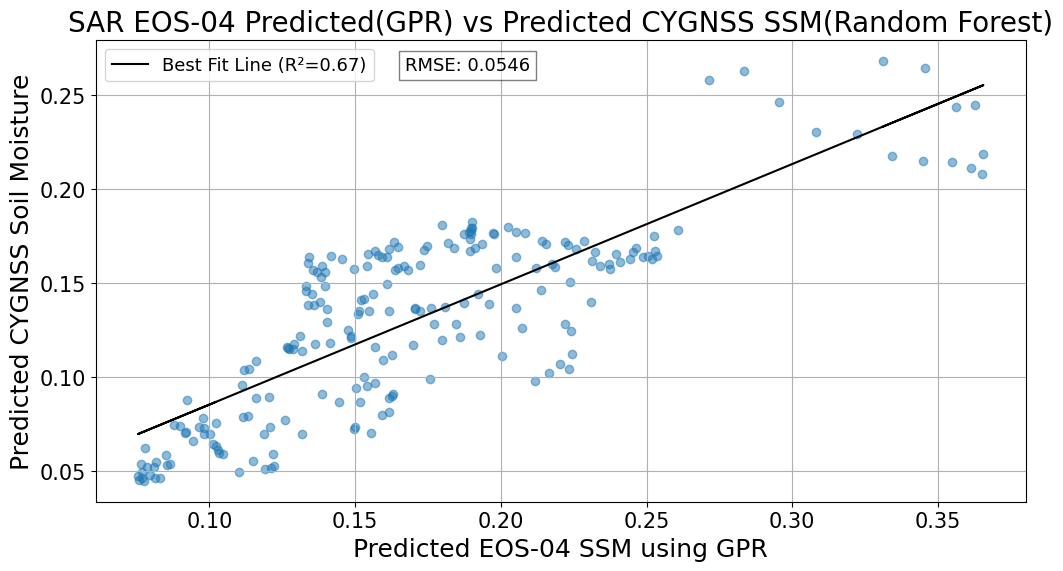

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress

# Data
file_path = '/content/drive/MyDrive/Earth Engine Exports/Combined Data/combined_data.xlsx'
df = pd.read_excel(file_path)

# Feature Engineering
df['SAR_temp'] = df['Interpolated_SAR_Data'] * df['mean_temperature_C']
df['SAR_ET'] = df['Interpolated_SAR_Data'] * df['ET']

# Preparing the features and target variable
features = df[['Interpolated_SAR_Data', 'mean_temperature_C', 'ET', 'Precipitation', 'SAR_temp', 'SAR_ET']]
target = df['CYGNSS_values']

# KNN Imputation for missing values in target
imputer_target = KNNImputer(n_neighbors=3)
target_imputed = imputer_target.fit_transform(target.values.reshape(-1, 1))
target = pd.Series(target_imputed.flatten())

# KNN Imputation for missing values in features
imputer_features = KNNImputer(n_neighbors=3)
features_imputed = imputer_features.fit_transform(features)
features = pd.DataFrame(features_imputed, columns=features.columns) # Convert back to DataFrame

# Feature Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initializing the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Grid Search
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='neg_mean_squared_error', cv=5)
grid_search_rf.fit(X_train, y_train)

# Best parameters and model
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

print(f"Best parameters for Random Forest: {best_params_rf}")

# Prediction and evaluation with the best Random Forest model
y_pred_rf_best = best_model_rf.predict(X_test)
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)

print(f"Optimized Random Forest RMSE: {rmse_rf_best}")
print(f"Optimized Random Forest MAE: {mae_rf_best}")

# Visualization for the optimized Random Forest model
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_rf_best, alpha=0.5, label='Random Forest Predictions')

# Best fit line
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred_rf_best)
plt.plot(y_test, slope * y_test + intercept, label=f'Best Fit Line (R²={r_value**2:.2f})', color='black')

plt.xlabel('Actual CYGNSS Values')
plt.ylabel('Predicted CYGNSS Values (Optimized Random Forest)')
plt.title('Optimized Random Forest Predictions vs Actual Values')
plt.legend()
plt.show()

# Adding Predictions to DataFrame for RMSE Comparison
df['Predicted_CYGNSS_RF'] = best_model_rf.predict(features_scaled)

# Ensure you have SAR data in your dataframe
df['SAR_Data'] = df['Interpolated_SAR_Data']

# Dropping rows with missing SAR data or predicted values
df_clean_rf = df.dropna(subset=['SAR_Data', 'Predicted_CYGNSS_RF'])

# RMSE between predicted CYGNSS values and SAR data
rmse_comparison_rf = np.sqrt(mean_squared_error(df_clean_rf['SAR_Data'], df_clean_rf['Predicted_CYGNSS_RF']))

print(f"RMSE between Predicted CYGNSS Values and SAR Data (Random Forest): {rmse_comparison_rf}")

# Visualization for SAR Data vs Predicted CYGNSS Values (Random Forest)
plt.figure(figsize=(12, 6))
plt.scatter(df_clean_rf['SAR_Data'], df_clean_rf['Predicted_CYGNSS_RF'], alpha=0.5)

# Best fit line
slope, intercept, r_value, p_value, std_err = linregress(df_clean_rf['SAR_Data'], df_clean_rf['Predicted_CYGNSS_RF'])
plt.plot(df_clean_rf['SAR_Data'], slope * df_clean_rf['SAR_Data'] + intercept, label=f'Best Fit Line (R²={r_value**2:.2f})', color='black')
plt.text(0.4, 0.945, f'RMSE: {rmse_comparison_rf:.4f}', fontsize=13, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Predicted EOS-04 SSM using GPR', fontsize = 18)
plt.ylabel('Predicted CYGNSS Soil Moisture', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('SAR EOS-04 Predicted(GPR) vs Predicted CYGNSS SSM(Random Forest)', fontsize = 20)
plt.legend(fontsize = 13)
plt.grid(True)
plt.show()


GBM Model

GBM Model

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Optimized Gradient Boosting RMSE: 0.036423753161070674
Optimized Gradient Boosting MAE: 0.02842877407074782
Optimized Gradient Boosting R^2: 0.6450250172428427


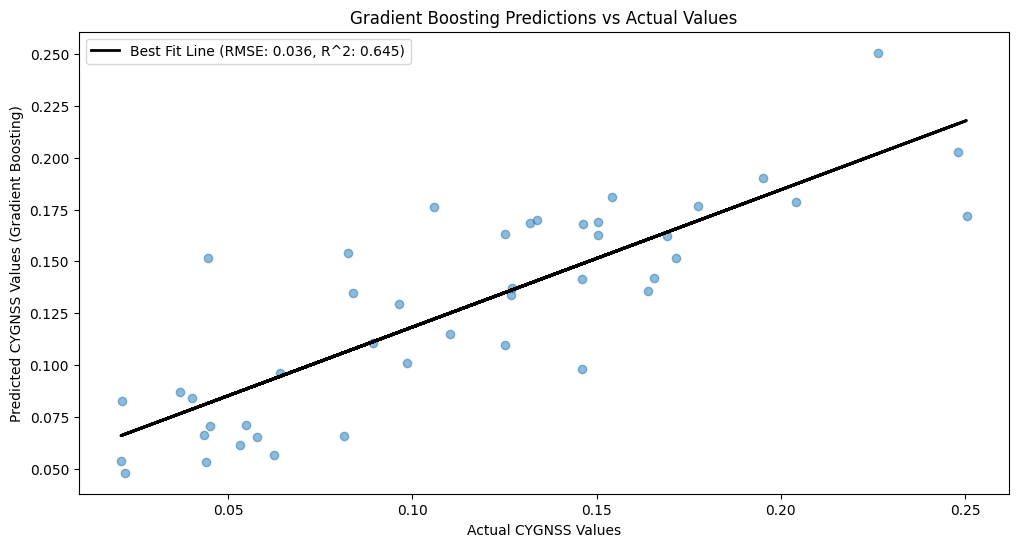

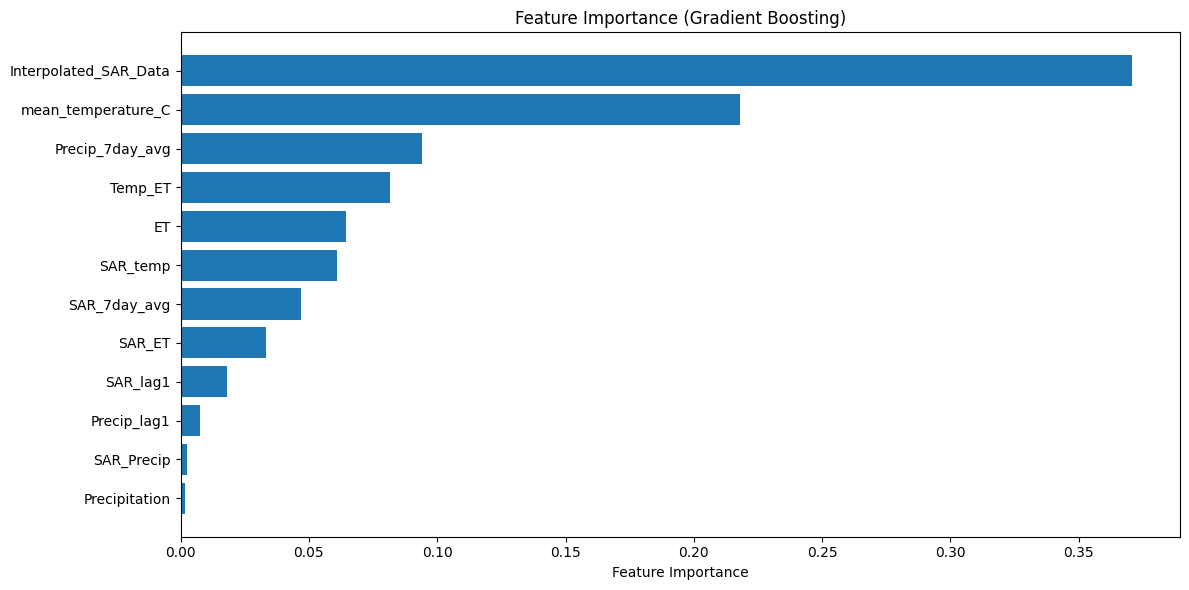

RMSE between Predicted CYGNSS Values and SAR Data (Gradient Boosting): 0.0554817448499498


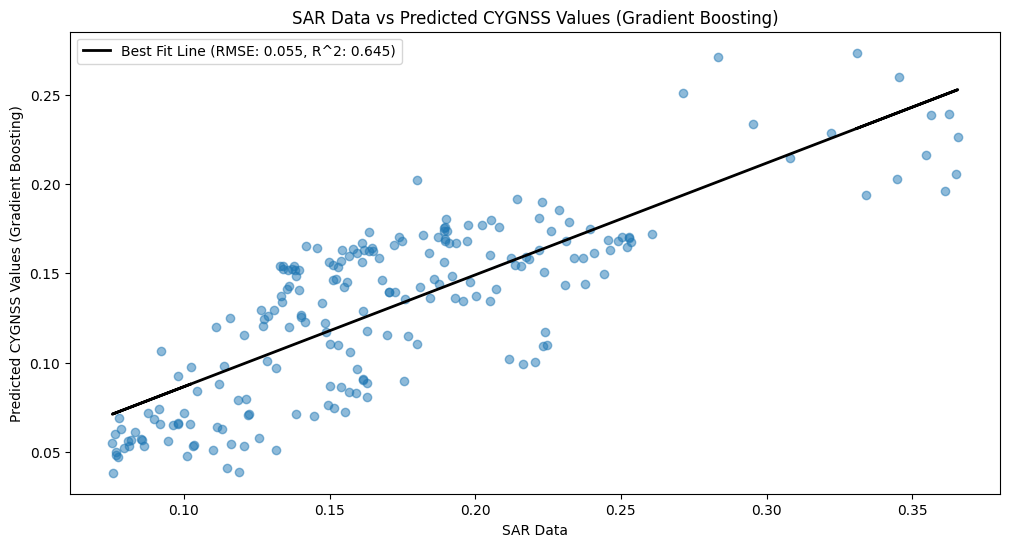

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# Data
file_path = '/content/drive/MyDrive/Earth Engine Exports/Combined Data/combined_data.xlsx'
df = pd.read_excel(file_path)

# Feature Engineering
df['SAR_temp'] = df['Interpolated_SAR_Data'] * df['mean_temperature_C']
df['SAR_ET'] = df['Interpolated_SAR_Data'] * df['ET']
df['SAR_Precip'] = df['Interpolated_SAR_Data'] * df['Precipitation']
df['Temp_ET'] = df['mean_temperature_C'] * df['ET']

# Rolling averages and lag features
df['SAR_7day_avg'] = df['Interpolated_SAR_Data'].rolling(window=7).mean()
df['Precip_7day_avg'] = df['Precipitation'].rolling(window=7).mean()
df['SAR_lag1'] = df['Interpolated_SAR_Data'].shift(1)
df['Precip_lag1'] = df['Precipitation'].shift(1)

# Features and target
features = df[['Interpolated_SAR_Data', 'mean_temperature_C', 'ET', 'Precipitation',
               'SAR_temp', 'SAR_ET', 'SAR_Precip', 'Temp_ET',
               'SAR_7day_avg', 'Precip_7day_avg', 'SAR_lag1', 'Precip_lag1']]
target = df['CYGNSS_values']

data_for_imputation = pd.concat([features, target], axis=1)

# KNN Imputation for any missing values in both features and target
imputer = KNNImputer(n_neighbors=5)
imputed_data = pd.DataFrame(imputer.fit_transform(data_for_imputation), columns=data_for_imputation.columns)

# Separating features and target after imputation
features_imputed = imputed_data.drop('CYGNSS_values', axis=1)
target_imputed = imputed_data['CYGNSS_values']

# Splitting
X_train, X_test, y_train, y_test = train_test_split(features_imputed, target_imputed, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Grid Search
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb,
                              scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search_gb.fit(X_train_scaled, y_train)

# Best parameters and model
best_params_gb = grid_search_gb.best_params_
best_model_gb = grid_search_gb.best_estimator_

print(f"Best parameters for Gradient Boosting: {best_params_gb}")

# Prediction and evaluation with the best Gradient Boosting model
y_pred_gb = best_model_gb.predict(X_test_scaled)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Optimized Gradient Boosting RMSE: {rmse_gb}")
print(f"Optimized Gradient Boosting MAE: {mae_gb}")
print(f"Optimized Gradient Boosting R^2: {r2_gb}")

# Visualization for the optimized Gradient Boosting model
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)

# Best-fit line (Linear Regression line)
model_lr = LinearRegression()
model_lr.fit(y_test.values.reshape(-1, 1), y_pred_gb)
y_best_fit = model_lr.predict(y_test.values.reshape(-1, 1))
plt.plot(y_test, y_best_fit, color='black', linewidth=2,
         label=f'Best Fit Line (RMSE: {rmse_gb:.3f}, R^2: {r2_gb:.3f})')

plt.xlabel('Actual CYGNSS Values')
plt.ylabel('Predicted CYGNSS Values (Gradient Boosting)')
plt.title('Gradient Boosting Predictions vs Actual Values')
plt.legend(loc='upper left')
plt.show()

# Feature Importance
feature_importance = best_model_gb.feature_importances_
feature_names = features.columns
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Gradient Boosting)')
plt.tight_layout()
plt.show()

# Comparison with SAR data
df['Predicted_CYGNSS_GB'] = best_model_gb.predict(scaler.transform(features_imputed))

df_clean_gb = df.dropna(subset=['Interpolated_SAR_Data', 'Predicted_CYGNSS_GB'])

rmse_comparison_gb = np.sqrt(mean_squared_error(df_clean_gb['Interpolated_SAR_Data'], df_clean_gb['Predicted_CYGNSS_GB']))

print(f"RMSE between Predicted CYGNSS Values and SAR Data (Gradient Boosting): {rmse_comparison_gb}")

# Visualization for SAR Data vs Predicted CYGNSS Values (Gradient Boosting)
plt.figure(figsize=(12, 6))
plt.scatter(df_clean_gb['Interpolated_SAR_Data'], df_clean_gb['Predicted_CYGNSS_GB'], alpha=0.5)

# Best-fit line for SAR Data vs Predicted CYGNSS Values
model_lr_sar = LinearRegression()
model_lr_sar.fit(df_clean_gb['Interpolated_SAR_Data'].values.reshape(-1, 1), df_clean_gb['Predicted_CYGNSS_GB'])
sar_best_fit = model_lr_sar.predict(df_clean_gb['Interpolated_SAR_Data'].values.reshape(-1, 1))
plt.plot(df_clean_gb['Interpolated_SAR_Data'], sar_best_fit, color='black', linewidth=2,
         label=f'Best Fit Line (RMSE: {rmse_comparison_gb:.3f}, R^2: {r2_gb:.3f})')

plt.xlabel('SAR Data')
plt.ylabel('Predicted CYGNSS Values (Gradient Boosting)')
plt.title('SAR Data vs Predicted CYGNSS Values (Gradient Boosting)')
plt.legend(loc='upper left')
plt.show()
